
DeepTables: Deep-learning Toolkit for Tabular data

https://github.com/DataCanvasIO/DeepTables

https://deeptables.readthedocs.io/en/latest/model_config.html#parameters

In [1]:
!pip install --no-index -U --find-links=/kaggle/input/deeptables-dependecies deeptables==0.2.5

Looking in links: /kaggle/input/deeptables-dependecies
Processing /kaggle/input/deeptables-dependecies/deeptables-0.2.5-py3-none-any.whl
Processing /kaggle/input/deeptables-dependecies/hypernets-0.3.1-py3-none-any.whl (from deeptables==0.2.5)
Processing /kaggle/input/deeptables-dependecies/XlsxWriter-3.1.9-py3-none-any.whl (from hypernets>=0.2.5.1->deeptables==0.2.5)
Processing /kaggle/input/deeptables-dependecies/paramiko-3.4.0-py3-none-any.whl (from hypernets>=0.2.5.1->deeptables==0.2.5)
Processing /kaggle/input/deeptables-dependecies/bcrypt-4.1.2-cp39-abi3-manylinux_2_28_x86_64.whl (from paramiko->hypernets>=0.2.5.1->deeptables==0.2.5)
Processing /kaggle/input/deeptables-dependecies/PyNaCl-1.5.0-cp36-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (from paramiko->hypernets>=0.2.5.1->deeptables==0.2.5)


In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
import gc
import math
import ctypes
import pickle
import random
import datetime
import holidays
import numpy as np
import pandas as pd
import polars as pl
import lightgbm as lgb
import matplotlib.pyplot as plt

import tensorflow as tf, deeptables as dt
from tensorflow.keras.utils import plot_model
from tensorflow_addons.optimizers import AdamW
from tensorflow.python.keras import backend as K
from deeptables.models import DeepTable, ModelConfig
from deeptables.models import deepnets

print('TensorFlow version:',tf.__version__)
print('DeepTables version:',dt.__version__)

TensorFlow version: 2.13.0
DeepTables version: 0.2.5


In [3]:
seed = 42
def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
seed_everything(seed=seed)

def clean_memory():
    gc.collect()
    ctypes.CDLL("libc.so.6").malloc_trim(0)
clean_memory()

# Classes

### 数据存储

In [4]:
class DataStorage:
    root = "/kaggle/input/predict-energy-behavior-of-prosumers"

    data_cols = [
        "target",
        "county",
        "is_business",
        "product_type",
        "is_consumption",
        "datetime",
        "row_id",
    ]
    client_cols = [
        "product_type",
        "county",
        "eic_count",
        "installed_capacity",
        "is_business",
        "date",
    ]
    gas_prices_cols = ["forecast_date", "lowest_price_per_mwh", "highest_price_per_mwh"]
    electricity_prices_cols = ["forecast_date", "euros_per_mwh"]
    forecast_weather_cols = [
        "latitude",
        "longitude",
        "hours_ahead",
        "temperature",
        "dewpoint",
        "cloudcover_high",
        "cloudcover_low",
        "cloudcover_mid",
        "cloudcover_total",
        "10_metre_u_wind_component",
        "10_metre_v_wind_component",
        "forecast_datetime",
        "direct_solar_radiation",
        "surface_solar_radiation_downwards",
        "snowfall",
        "total_precipitation",
    ]
    historical_weather_cols = [
        "datetime",
        "temperature",
        "dewpoint",
        "rain",
        "snowfall",
        "surface_pressure",
        "cloudcover_total",
        "cloudcover_low",
        "cloudcover_mid",
        "cloudcover_high",
        "windspeed_10m",
        "winddirection_10m",
        "shortwave_radiation",
        "direct_solar_radiation",
        "diffuse_radiation",
        "latitude",
        "longitude",
    ]
    location_cols = ["longitude", "latitude", "county"]
    target_cols = [
        "target",
        "county",
        "is_business",
        "product_type",
        "is_consumption",
        "datetime",
    ]

    def __init__(self):
        self.df_data = pl.read_csv(
            os.path.join(self.root, "train.csv"),
            columns=self.data_cols,
            try_parse_dates=True,
        )
        self.df_client = pl.read_csv(
            os.path.join(self.root, "client.csv"),
            columns=self.client_cols,
            try_parse_dates=True,
        )
        self.df_gas_prices = pl.read_csv(
            os.path.join(self.root, "gas_prices.csv"),
            columns=self.gas_prices_cols,
            try_parse_dates=True,
        )
        self.df_electricity_prices = pl.read_csv(
            os.path.join(self.root, "electricity_prices.csv"),
            columns=self.electricity_prices_cols,
            try_parse_dates=True,
        )
        self.df_forecast_weather = pl.read_csv(
            os.path.join(self.root, "forecast_weather.csv"),
            columns=self.forecast_weather_cols,
            try_parse_dates=True,
        )
        self.df_historical_weather = pl.read_csv(
            os.path.join(self.root, "historical_weather.csv"),
            columns=self.historical_weather_cols,
            try_parse_dates=True,
        )
        self.df_weather_station_to_county_mapping = pl.read_csv(
            os.path.join(self.root, "weather_station_to_county_mapping.csv"),
            columns=self.location_cols,
            try_parse_dates=True,
        )
        self.df_data = self.df_data.filter(
            pl.col("datetime") >= pd.to_datetime("2022-01-01")
        )
        self.df_target = self.df_data.select(self.target_cols)

        self.schema_data = self.df_data.schema
        self.schema_client = self.df_client.schema
        self.schema_gas_prices = self.df_gas_prices.schema
        self.schema_electricity_prices = self.df_electricity_prices.schema
        self.schema_forecast_weather = self.df_forecast_weather.schema
        self.schema_historical_weather = self.df_historical_weather.schema
        self.schema_target = self.df_target.schema

        self.df_weather_station_to_county_mapping = (
            self.df_weather_station_to_county_mapping.with_columns(
                pl.col("latitude").cast(pl.datatypes.Float32),
                pl.col("longitude").cast(pl.datatypes.Float32),
            )
        )

    def update_with_new_data(
        self,
        df_new_client,
        df_new_gas_prices,
        df_new_electricity_prices,
        df_new_forecast_weather,
        df_new_historical_weather,
        df_new_target,
    ):
        df_new_client = pl.from_pandas(
            df_new_client[self.client_cols], schema_overrides=self.schema_client
        )
        df_new_gas_prices = pl.from_pandas(
            df_new_gas_prices[self.gas_prices_cols],
            schema_overrides=self.schema_gas_prices,
        )
        df_new_electricity_prices = pl.from_pandas(
            df_new_electricity_prices[self.electricity_prices_cols],
            schema_overrides=self.schema_electricity_prices,
        )
        df_new_forecast_weather = pl.from_pandas(
            df_new_forecast_weather[self.forecast_weather_cols],
            schema_overrides=self.schema_forecast_weather,
        )
        df_new_historical_weather = pl.from_pandas(
            df_new_historical_weather[self.historical_weather_cols],
            schema_overrides=self.schema_historical_weather,
        )
        df_new_target = pl.from_pandas(
            df_new_target[self.target_cols], schema_overrides=self.schema_target
        )

        self.df_client = pl.concat([self.df_client, df_new_client]).unique(
            ["date", "county", "is_business", "product_type"]
        )
        self.df_gas_prices = pl.concat([self.df_gas_prices, df_new_gas_prices]).unique(
            ["forecast_date"]
        )
        self.df_electricity_prices = pl.concat(
            [self.df_electricity_prices, df_new_electricity_prices]
        ).unique(["forecast_date"])
        self.df_forecast_weather = pl.concat(
            [self.df_forecast_weather, df_new_forecast_weather]
        ).unique(["forecast_datetime", "latitude", "longitude", "hours_ahead"])
        self.df_historical_weather = pl.concat(
            [self.df_historical_weather, df_new_historical_weather]
        ).unique(["datetime", "latitude", "longitude"])
        self.df_target = pl.concat([self.df_target, df_new_target]).unique(
            ["datetime", "county", "is_business", "product_type", "is_consumption"]
        )

    def preprocess_test(self, df_test):
        df_test = df_test.rename(columns={"prediction_datetime": "datetime"})
        df_test = pl.from_pandas(
            df_test[self.data_cols[1:]], schema_overrides=self.schema_data
        )
        return df_test

### 特征生成器

In [5]:
class FeaturesGenerator:
    def __init__(self, data_storage):
        self.data_storage = data_storage
        self.estonian_holidays = list(
            holidays.country_holidays("EE", years=range(2021, 2026)).keys()
        )

    def _add_general_features(self, df_features):
        df_features = (
            df_features.with_columns(
                pl.col("datetime").dt.ordinal_day().alias("dayofyear"),
                pl.col("datetime").dt.hour().alias("hour"),
                pl.col("datetime").dt.day().alias("day"),
                pl.col("datetime").dt.weekday().alias("weekday"),
                pl.col("datetime").dt.month().alias("month"),
                pl.col("datetime").dt.year().alias("year"),
            )
            .with_columns(
                pl.concat_str(
                    "county",
                    "is_business",
                    "product_type",
                    "is_consumption",
                    separator="_",
                ).alias("segment"),
            )
            .with_columns(
                (np.pi * pl.col("dayofyear") / 183).sin().alias("sin(dayofyear)"),
                (np.pi * pl.col("dayofyear") / 183).cos().alias("cos(dayofyear)"),
                (np.pi * pl.col("hour") / 12).sin().alias("sin(hour)"),
                (np.pi * pl.col("hour") / 12).cos().alias("cos(hour)"),
            )
        )
        return df_features

    def _add_client_features(self, df_features):
        df_client = self.data_storage.df_client

        df_features = df_features.join(
            df_client.with_columns(
                (pl.col("date") + pl.duration(days=2)).cast(pl.Date)
            ),
            on=["county", "is_business", "product_type", "date"],
            how="left",
        )
        return df_features
    
    def is_country_holiday(self, row):
        return (
            datetime.date(row["year"], row["month"], row["day"])
            in self.estonian_holidays
        )

    def _add_holidays_features(self, df_features):
        df_features = df_features.with_columns(
            pl.struct(["year", "month", "day"])
            .apply(self.is_country_holiday)
            .alias("is_country_holiday")
        )
        return df_features

    def _add_forecast_weather_features(self, df_features):
        df_forecast_weather = self.data_storage.df_forecast_weather
        df_weather_station_to_county_mapping = (
            self.data_storage.df_weather_station_to_county_mapping
        )

        df_forecast_weather = (
            df_forecast_weather.rename({"forecast_datetime": "datetime"})
            .filter((pl.col("hours_ahead") >= 22) & pl.col("hours_ahead") <= 45)
            .drop("hours_ahead")
            .with_columns(
                pl.col("latitude").cast(pl.datatypes.Float32),
                pl.col("longitude").cast(pl.datatypes.Float32),
            )
            .join(
                df_weather_station_to_county_mapping,
                how="left",
                on=["longitude", "latitude"],
            )
            .drop("longitude", "latitude")
        )

        df_forecast_weather_date = (
            df_forecast_weather.group_by("datetime").mean().drop("county")
        )

        df_forecast_weather_local = (
            df_forecast_weather.filter(pl.col("county").is_not_null())
            .group_by("county", "datetime")
            .mean()
        )

        for hours_lag in [0, 7 * 24]:
            df_features = df_features.join(
                df_forecast_weather_date.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ),
                on="datetime",
                how="left",
                suffix=f"_forecast_{hours_lag}h",
            )
            df_features = df_features.join(
                df_forecast_weather_local.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ),
                on=["county", "datetime"],
                how="left",
                suffix=f"_forecast_local_{hours_lag}h",
            )

        return df_features

    def _add_historical_weather_features(self, df_features):
        df_historical_weather = self.data_storage.df_historical_weather
        df_weather_station_to_county_mapping = (
            self.data_storage.df_weather_station_to_county_mapping
        )

        df_historical_weather = (
            df_historical_weather.with_columns(
                pl.col("latitude").cast(pl.datatypes.Float32),
                pl.col("longitude").cast(pl.datatypes.Float32),
            )
            .join(
                df_weather_station_to_county_mapping,
                how="left",
                on=["longitude", "latitude"],
            )
            .drop("longitude", "latitude")
        )

        df_historical_weather_date = (
            df_historical_weather.group_by("datetime").mean().drop("county")
        )

        df_historical_weather_local = (
            df_historical_weather.filter(pl.col("county").is_not_null())
            .group_by("county", "datetime")
            .mean()
        )

        for hours_lag in [2 * 24, 7 * 24]:
            df_features = df_features.join(
                df_historical_weather_date.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ),
                on="datetime",
                how="left",
                suffix=f"_historical_{hours_lag}h",
            )
            df_features = df_features.join(
                df_historical_weather_local.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ),
                on=["county", "datetime"],
                how="left",
                suffix=f"_historical_local_{hours_lag}h",
            )

        for hours_lag in [1 * 24]:
            df_features = df_features.join(
                df_historical_weather_date.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag),
                    pl.col("datetime").dt.hour().alias("hour"),
                )
                .filter(pl.col("hour") <= 10)
                .drop("hour"),
                on="datetime",
                how="left",
                suffix=f"_historical_{hours_lag}h",
            )

        return df_features

    def _add_target_features(self, df_features):
        df_target = self.data_storage.df_target

        df_target_all_type_sum = (
            df_target.group_by(["datetime", "county", "is_business", "is_consumption"])
            .sum()
            .drop("product_type")
        )

        df_target_all_county_type_sum = (
            df_target.group_by(["datetime", "is_business", "is_consumption"])
            .sum()
            .drop("product_type", "county")
        )

        for hours_lag in [
            2 * 24,
            3 * 24,
            4 * 24,
            5 * 24,
            6 * 24,
            7 * 24,
            8 * 24,
            9 * 24,
            10 * 24,
            11 * 24,
            12 * 24,
            13 * 24,
            14 * 24,
        ]:
            df_features = df_features.join(
                df_target.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ).rename({"target": f"target_{hours_lag}h"}),
                on=[
                    "county",
                    "is_business",
                    "product_type",
                    "is_consumption",
                    "datetime",
                ],
                how="left",
            )

        for hours_lag in [2 * 24, 3 * 24, 7 * 24, 14 * 24]:
            df_features = df_features.join(
                df_target_all_type_sum.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ).rename({"target": f"target_all_type_sum_{hours_lag}h"}),
                on=["county", "is_business", "is_consumption", "datetime"],
                how="left",
            )

            df_features = df_features.join(
                df_target_all_county_type_sum.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ).rename({"target": f"target_all_county_type_sum_{hours_lag}h"}),
                on=["is_business", "is_consumption", "datetime"],
                how="left",
                suffix=f"_all_county_type_sum_{hours_lag}h",
            )

        cols_for_stats = [
            f"target_{hours_lag}h" for hours_lag in [2 * 24, 3 * 24, 4 * 24, 5 * 24]
        ]
        df_features = df_features.with_columns(
            df_features.select(cols_for_stats).mean(axis=1).alias(f"target_mean"),
            df_features.select(cols_for_stats)
            .transpose()
            .std()
            .transpose()
            .to_series()
            .alias(f"target_std"),
        )

        for target_prefix, lag_nominator, lag_denomonator in [
            ("target", 24 * 7, 24 * 14),
            ("target", 24 * 2, 24 * 9),
            ("target", 24 * 3, 24 * 10),
            ("target", 24 * 2, 24 * 3),
            ("target_all_type_sum", 24 * 2, 24 * 3),
            ("target_all_type_sum", 24 * 7, 24 * 14),
            ("target_all_county_type_sum", 24 * 2, 24 * 3),
            ("target_all_county_type_sum", 24 * 7, 24 * 14),
        ]:
            df_features = df_features.with_columns(
                (
                    pl.col(f"{target_prefix}_{lag_nominator}h")
                    / (pl.col(f"{target_prefix}_{lag_denomonator}h") + 1e-3)
                ).alias(f"{target_prefix}_ratio_{lag_nominator}_{lag_denomonator}")
            )

        return df_features

    def _reduce_memory_usage(self, df_features):
        df_features = df_features.with_columns(pl.col(pl.Float64).cast(pl.Float32))
        return df_features

    def _drop_columns(self, df_features):
        df_features = df_features.drop(
            "date", "datetime", "hour", "dayofyear"
        )
        return df_features

    def _to_pandas(self, df_features, y):
        cat_cols = [
            "county",
            "is_business",
            "product_type",
            "is_consumption",
            "segment",
        ]

        if y is not None:
            df_features = pd.concat([df_features.to_pandas(), y.to_pandas()], axis=1)
        else:
            df_features = df_features.to_pandas()

        df_features = df_features.set_index("row_id")
        df_features[cat_cols] = df_features[cat_cols].astype("category")

        return df_features

    def generate_features(self, df_prediction_items):
        if "target" in df_prediction_items.columns:
            df_prediction_items, y = (
                df_prediction_items.drop("target"),
                df_prediction_items.select("target"),
            )
        else:
            y = None

        df_features = df_prediction_items.with_columns(
            pl.col("datetime").cast(pl.Date).alias("date"),
        )

        for add_features in [
            self._add_general_features,
            self._add_client_features,
            self._add_forecast_weather_features,
            self._add_historical_weather_features,
            self._add_target_features,
            self._add_holidays_features,
            self._reduce_memory_usage,
            self._drop_columns,
        ]:
            df_features = add_features(df_features)

        df_features = self._to_pandas(df_features, y)

        return df_features

# 特征生成

In [6]:
%%time
data_storage = DataStorage()
features_generator = FeaturesGenerator(data_storage=data_storage)

df_train_features = features_generator.generate_features(data_storage.df_data)
df_train_features = df_train_features[df_train_features['target'].notnull()]

clean_memory()
df_train_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1651902 entries, 366048 to 2018351
Columns: 166 entries, county to target
dtypes: bool(1), category(5), float32(154), float64(2), int32(1), uint32(3)
memory usage: 1.0 GB
CPU times: user 52.2 s, sys: 9.77 s, total: 1min 2s
Wall time: 28.8 s


# Train Model

### LearningRateScheduler

Learning rate schedule: 1e-07 to 0.001 to 1e-07


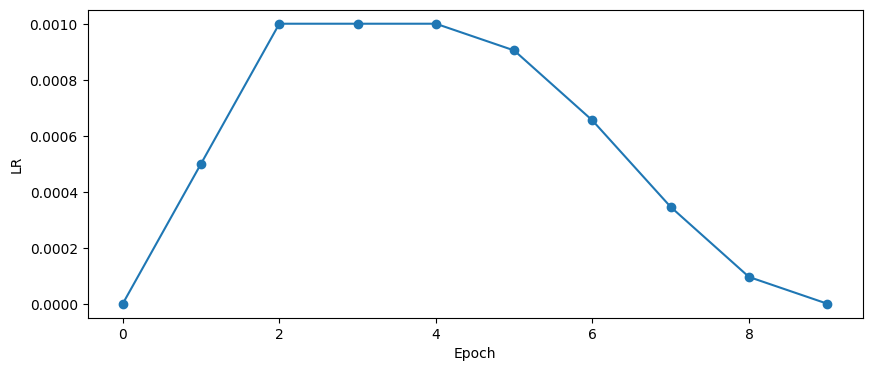

In [7]:
LR_START = 1e-7
LR_MAX = 1e-3
LR_MIN = 1e-7
LR_RAMPUP_EPOCHS = 2
LR_SUSTAIN_EPOCHS = 2
EPOCHS = 10

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        decay_total_epochs = EPOCHS - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS - 1
        decay_epoch_index = epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS
        phase = math.pi * decay_epoch_index / decay_total_epochs
        cosine_decay = 0.5 * (1 + math.cos(phase))
        lr = (LR_MAX - LR_MIN) * cosine_decay + LR_MIN
        
    return lr

rng = [i for i in range(EPOCHS)]
lr_y = [lrfn(x) for x in rng]
plt.figure(figsize=(10, 4))
plt.plot(rng, lr_y, '-o')
plt.xlabel('Epoch'); plt.ylabel('LR')
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}". \
      format(lr_y[0], max(lr_y), lr_y[-1]))
LR = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)

### Model

nn = True
lgb = True

 nn model consumption training. 

01-30 03:10:02 I deeptables.m.deeptable.py 338 - X.Shape=(825951, 165), y.Shape=(825951,), batch_size=512, config=ModelConfig(name='conf-1', nets=['dnn_nets'], categorical_columns='auto', exclude_columns=[], task='regression', pos_label=None, metrics='MeanAbsoluteError', auto_categorize=False, cat_exponent=0.5, cat_remain_numeric=True, auto_encode_label=True, auto_imputation=True, auto_discrete=True, auto_discard_unique=True, apply_gbm_features=False, gbm_params={}, gbm_feature_type='embedding', fixed_embedding_dim=False, embeddings_output_dim=4, embeddings_initializer='uniform', embeddings_regularizer=None, embeddings_activity_regularizer=None, dense_dropout=0, embedding_dropout=0.3, stacking_op='add', output_use_bias=False, apply_class_weight=False, optimizer=<tensorflow_addons.optimizers.weight_decay_optimizers.AdamW object at 0x7a2e6835bd00>, loss='MeanAbsoluteError', dnn_params={'hidden_units': ((512, 0.3, True), (256, 0.3, T

01-30 03:10:03 W hypernets.t.cache.py 210 - AttributeError: Can't pickle local object 'make_gradient_clipnorm_fn.<locals>.<lambda>'
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/cache.py", line 165, in _cache_call
    cache_key = tb.data_hasher()(key_items)
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 20, in __call__
    for x in self._iter_data(data):
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 58, in _iter_data
    yield from self._iter_data(v)
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 53, in _iter_data
    yield from self._iter_data(x)
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 61, in _iter_data
    pickle.dump(data, buf, protocol=pickle.HIGHEST_PROTOCOL)



01-30 03:10:04 I deeptables.m.preprocessor.py 261 - Preparing features...
01-30 03:10:05 I deeptables.m.preprocessor.py 336 - Preparing features taken 1.4566707611083984s
01-30 03:10:05 I deeptables.m.preprocessor.py 341 - Data imputation...
01-30 03:10:11 I deeptables.m.preprocessor.py 383 - Imputation taken 5.869945526123047s
01-30 03:10:11 I deeptables.m.preprocessor.py 388 - Categorical encoding...
01-30 03:10:11 I deeptables.m.preprocessor.py 393 - Categorical encoding taken 0.19082331657409668s
01-30 03:10:11 I deeptables.m.preprocessor.py 398 - Data discretization...
01-30 03:10:11 I hypernets.t.sklearn_ex.py 716 - 159 variables to discrete.
01-30 03:10:18 I deeptables.m.preprocessor.py 404 - Discretization taken 6.421814680099487s
01-30 03:10:20 I deeptables.m.preprocessor.py 196 - fit_transform taken 17.132794618606567s
01-30 03:10:20 I deeptables.m.deeptable.py 354 - Training...
01-30 03:10:20 I deeptables.m.deeptable.py 752 - Injected a callback [EarlyStopping]. monitor:val_

01-30 03:16:29 W hypernets.t.cache.py 210 - AttributeError: Can't pickle local object 'make_gradient_clipnorm_fn.<locals>.<lambda>'
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/cache.py", line 165, in _cache_call
    cache_key = tb.data_hasher()(key_items)
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 20, in __call__
    for x in self._iter_data(data):
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 58, in _iter_data
    yield from self._iter_data(v)
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 53, in _iter_data
    yield from self._iter_data(x)
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 61, in _iter_data
    pickle.dump(data, buf, protocol=pickle.HIGHEST_PROTOCOL)



01-30 03:16:29 I deeptables.m.preprocessor.py 261 - Preparing features...
01-30 03:16:31 I deeptables.m.preprocessor.py 336 - Preparing features taken 1.3168015480041504s
01-30 03:16:31 I deeptables.m.preprocessor.py 341 - Data imputation...
01-30 03:16:36 I deeptables.m.preprocessor.py 383 - Imputation taken 5.503889799118042s
01-30 03:16:36 I deeptables.m.preprocessor.py 388 - Categorical encoding...
01-30 03:16:36 I deeptables.m.preprocessor.py 393 - Categorical encoding taken 0.18285131454467773s
01-30 03:16:36 I deeptables.m.preprocessor.py 398 - Data discretization...
01-30 03:16:36 I hypernets.t.sklearn_ex.py 716 - 159 variables to discrete.
01-30 03:16:42 I deeptables.m.preprocessor.py 404 - Discretization taken 5.770615339279175s
01-30 03:16:44 I deeptables.m.preprocessor.py 196 - fit_transform taken 15.442279577255249s
01-30 03:16:44 I deeptables.m.deeptable.py 354 - Training...
1 Physical GPUs, 1 Logical GPUs
01-30 03:16:46 I deeptables.u.dataset_generator.py 240 - create da

1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.



 lgb model production training. 

CPU times: user 2h 7min 42s, sys: 4min 3s, total: 2h 11min 46s
Wall time: 38min 48s


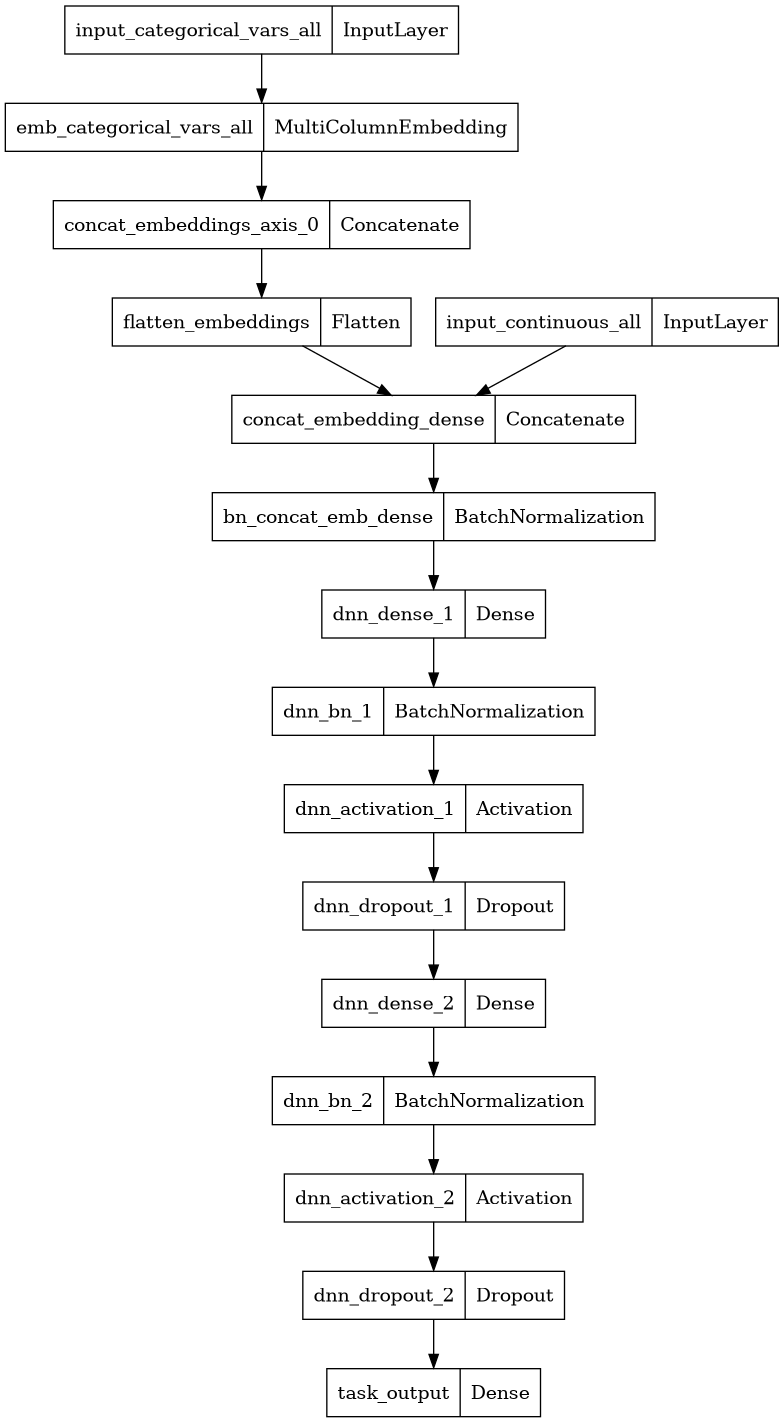

In [8]:
%%time
class CFG:
    nn = True
    lgb = True
    ens_weights = {'nn': 0.5, 'lgb': 0.5}
    epochs = 10
    batch_size = 512
    valid_size = 5e-2
    LR_Scheduler = []  # [LR]
    optimizer = AdamW(learning_rate=1e-3, weight_decay=9e-7)
     
class Model:
    def __init__(self):
        self.conf = ModelConfig(auto_imputation=True,
                                auto_discrete=True,
                                auto_discard_unique=True,
                                categorical_columns='auto',
                                fixed_embedding_dim=False,
                                embeddings_output_dim=4,
                                embedding_dropout=0.3,
                                nets=['dnn_nets'],
                                dnn_params={
                                    'hidden_units': ((512, 0.3, True),
                                                     (256, 0.3, True)),
                                    'dnn_activation': 'relu',
                                },
                                stacking_op='add',
                                output_use_bias=False,
                                optimizer=CFG.optimizer,
                                task='regression',
                                loss='MeanAbsoluteError',
                                metrics='MeanAbsoluteError',
                                earlystopping_patience=1,
                                )
        
        self.lgb_params = {"n_estimators": 2500,
                           "learning_rate": 0.06,
                           "max_depth": 16,
                           "num_leaves": 500,
                           "reg_alpha": 3.5,
                           "reg_lambda": 1.5,
                           "colsample_bytree": 0.9,
                           "colsample_bynode": 0.6,
                           "min_child_samples": 50,
                           "random_state": 0,
                           "objective": "regression_l1",
                           "device": "gpu",
                           "n_jobs": 4,
                           "verbose": -1,
                           }
        
        self.nn_model_consumption = DeepTable(config=self.conf)  
        self.nn_model_production = DeepTable(config=self.conf)
        
        self.lgb_model_consumption = lgb.LGBMRegressor(**self.lgb_params)
        self.lgb_model_production = lgb.LGBMRegressor(**self.lgb_params)

    def fit(self, df_train_features):
        print('nn = '+str(CFG.nn))
        print('lgb = '+str(CFG.lgb))
        
        if CFG.nn == True:
            
            print('\n',"nn model consumption training.",'\n')
            mask = df_train_features["is_consumption"] == 1
            self.nn_model_consumption.fit(
                X=df_train_features[mask].drop(columns=["target"]),
                y=df_train_features[mask]["target"]
                - df_train_features[mask]["target_48h"].fillna(0),
                validation_split=CFG.valid_size, shuffle=False,
                batch_size=CFG.batch_size, epochs=CFG.epochs, verbose=2,
                callbacks=CFG.LR_Scheduler
            )
        
            # Avoid saving error
            with K.name_scope(CFG.optimizer.__class__.__name__):
                for i, var in enumerate(CFG.optimizer.weights):
                    name = 'variable{}'.format(i)
                    CFG.optimizer.weights[i] = tf.Variable(var, name=name)
            self.conf = self.conf._replace(optimizer=CFG.optimizer)   
            self.nn_model_production = DeepTable(config=self.conf)
            
            print('\n',"nn model production training.",'\n')
            mask = df_train_features["is_consumption"] == 0
            self.nn_model_production.fit(
                X=df_train_features[mask].drop(columns=["target"]),
                y=df_train_features[mask]["target"]
                - df_train_features[mask]["target_48h"].fillna(0),
                validation_split=CFG.valid_size, shuffle=False,
                batch_size=CFG.batch_size, epochs=CFG.epochs, verbose=2,
                callbacks=CFG.LR_Scheduler
            )
        
        if CFG.lgb == True:
            
            print('\n',"lgb model consumption training.")
            mask = df_train_features["is_consumption"] == 1
            self.lgb_model_consumption.fit(
                X=df_train_features[mask].drop(columns=["target"]),
                y=df_train_features[mask]["target"]
                - df_train_features[mask]["target_48h"].fillna(0),
            )
        
            print('\n',"lgb model production training.",'\n')
            mask = df_train_features["is_consumption"] == 0
            self.lgb_model_production.fit(
                X=df_train_features[mask].drop(columns=["target"]),
                y=df_train_features[mask]["target"]
                - df_train_features[mask]["target_48h"].fillna(0),
            )
        
    def plot_nn_model(self):
        if CFG.nn == True:
            return plot_model(self.nn_model_consumption.get_model().model)    

    def predict(self, df_features):
        predictions = np.zeros(len(df_features))
        
        if CFG.nn == True and CFG.lgb == True:
            
            print('\n',"nn & lgb model consumption prediction.",'\n')
            mask = df_features["is_consumption"] == 1
            predictions[mask.values] = np.clip(
                df_features[mask]["target_48h"].fillna(0).values
                + CFG.ens_weights['nn'] * (self.nn_model_consumption.predict(df_features[mask])[:,0])
                + CFG.ens_weights['lgb'] * (self.lgb_model_consumption.predict(df_features[mask])),
                0,
                np.inf,
            )
        
            print('\n',"nn & lgb model production prediction.",'\n')
            mask = df_features["is_consumption"] == 0
            predictions[mask.values] = np.clip(
                df_features[mask]["target_48h"].fillna(0).values
                + CFG.ens_weights['nn'] * (self.nn_model_production.predict(df_features[mask])[:,0])
                + CFG.ens_weights['lgb'] * (self.lgb_model_production.predict(df_features[mask])),
                0,
                np.inf,
            )
        
        elif CFG.nn == True and CFG.lgb == False:
            
            print('\n',"nn model consumption prediction.",'\n')
            mask = df_features["is_consumption"] == 1
            predictions[mask.values] = np.clip(
                df_features[mask]["target_48h"].fillna(0).values
                + self.nn_model_consumption.predict(df_features[mask])[:,0],
                0,
                np.inf,
            )
            
            print('\n',"nn model production prediction.",'\n')
            mask = df_features["is_consumption"] == 0
            predictions[mask.values] = np.clip(
                df_features[mask]["target_48h"].fillna(0).values
                + self.nn_model_production.predict(df_features[mask])[:,0],
                0,
                np.inf,
            )
            
        elif CFG.nn == False and CFG.lgb == True:
            
            print('\n',"lgb model consumption prediction.",'\n')
            mask = df_features["is_consumption"] == 1
            predictions[mask.values] = np.clip(
                df_features[mask]["target_48h"].fillna(0).values
                + self.lgb_model_consumption.predict(df_features[mask]),
                0,
                np.inf,
            )
            
            print('\n',"lgb model production prediction.",'\n')
            mask = df_features["is_consumption"] == 0
            predictions[mask.values] = np.clip(
                df_features[mask]["target_48h"].fillna(0).values
                + self.lgb_model_production.predict(df_features[mask]),
                0,
                np.inf,
            )
            
        else:
            raise ValueError("No models has been trained.")
            
        return predictions
    
    
model = Model()
model.fit(df_train_features)
clean_memory()
model.plot_nn_model()

# Submit API

In [9]:
import enefit

env = enefit.make_env()
iter_test = env.iter_test()

In [10]:
%%time
for (
    df_test, 
    df_new_target, 
    df_new_client, 
    df_new_historical_weather,
    df_new_forecast_weather, 
    df_new_electricity_prices, 
    df_new_gas_prices, 
    df_sample_prediction
) in iter_test:

    data_storage.update_with_new_data(
        df_new_client=df_new_client,
        df_new_gas_prices=df_new_gas_prices,
        df_new_electricity_prices=df_new_electricity_prices,
        df_new_forecast_weather=df_new_forecast_weather,
        df_new_historical_weather=df_new_historical_weather,
        df_new_target=df_new_target
    )
    df_test = data_storage.preprocess_test(df_test)
    
    df_test_features = features_generator.generate_features(df_test)
    df_sample_prediction["target"] = model.predict(df_test_features)
    
    env.predict(df_sample_prediction)

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.

 nn & lgb model consumption prediction. 

01-30 03:48:55 I deeptables.m.deeptable.py 685 - Perform prediction...
01-30 03:48:55 I deeptables.m.preprocessor.py 242 - Transform [X]...
01-30 03:48:56 I deeptables.m.preprocessor.py 249 - transform_X taken 0.30687785148620605s
01-30 03:48:56 I deeptables.m.deepmodel.py 130 - Performing predictions...
01-30 03:48:56 I deeptables.u.dataset_generator.py 240 - create dataset generator with _TFDGForPandas, batch_size=128, shuffle=False, drop_remainder=False
01-30 03:48:57 I deeptables.m.deeptable.py 559 - predict_proba taken 1.2668683528900146s

 nn & lgb model production prediction. 

01-30 03:48:57 I deeptables.m.deeptable.py 685 - Perform prediction...
01-30 03:48:57 I deeptables.m.preprocessor.py 242 - Transform [X]...
01-30 03:48:57 I deeptables.m.preprocessor.py 249 - transform_X taken 0.30281782150268555s
01-30 03: